# 1. Business understanding

The goal of the project is to make a book recommender with **Singular Value Decomposition** (**SVD**) algorithm, a collaborative filtering technique based on matrix factorization. The work is based on two datasets, one that contains user book rating pairs and another with book metadata such as title, author, and genre. The aim of the project is to train a recommendation model that can predict a user's rating for a book and give book suggestions.

**Research question**
<br>
The question the project is trying to answer is:
> Can a collaborative filtering model based on SVD accurately predict a user's rating for a book they have not read, and how well can it recommend books that align with the user's preferences?

This question guides the project work through data exploration, model training, and evaluation with the goal of improving personalized recommendations on platforms used to help users discover books.

The main requirement is to build and evaluate a recommendation model that can do accurate predictions of ratings and also produce best book suggestions for users. A constraint is that the dataset is very large, which makes it more challenging to handle effectively due to computational costs and the high sparsity of user-book ratings that limits the data density for the model training. The expected outcome is a validated book recommender that can give accurate predictions, relevant book recommendations, and potentially reveal patterns in user reading preferences.

# 2. Data understanding

## Introduction

**The Goodbooks-10k-extended** dataset is derived from [Goodreads](https://www.goodreads.com/) (a platform for rating books and discovering them) and it combines book metadata with user rating data. The [books_enriched.csv](https://github.com/malcolmosh/goodbooks-10k-extended/blob/master/books_enriched.csv) file contains information on **100000** popular books, with authors, publication details, genres, and collected ratings statistics. The [ratings.csv](https://github.com/malcolmosh/goodbooks-10k-extended/blob/master/ratings.csv) file contains almost **6** million individual ratings from over **53000** users by linking the reader to the books they have rated on a scale of **1-5** stars. These two files will be used to build a book recommender.

The following table introduces all the variables in the books_enriched.csv dataset with their descriptions:

| Variable                   | Description |
|-----------------------------|-------------|
| **index**                  | Row index (book ID in the CSV). |
| **authors**                | Main author(s) of the book. |
| **average_rating**         | Average Goodreads rating (1–5). |
| **best_book_id**           | Goodreads ID of the most popular edition. |
| **book_id**                | Internal book ID (1–10000). |
| **books_count**            | Number of editions of this work listed on Goodreads. |
| **description**            | Text summary of the book’s content. |
| **genres**                 | Cleaned list of main Goodreads genres (parsed from user shelves). |
| **goodreads_book_id**      | Goodreads ID of a specific edition. |
| **image_url**              | URL to the book’s cover image. |
| **isbn**                   | International Standard Book Number (10-digit). |
| **isbn13**                 | International Standard Book Number (13-digit). |
| **language_code**          | Language code of the book (e.g., “en”, “fr”). |
| **original_publication_year** | Year the book was first published. |
| **original_title**         | Original title of the book (if different from edition). |
| **pages**                  | Number of pages in the book. |
| **publishDate**            | Publication date (YYYY-MM-DD format if available). |
| **ratings_1**              | Number of 1-star ratings. |
| **ratings_2**              | Number of 2-star ratings. |
| **ratings_3**              | Number of 3-star ratings. |
| **ratings_4**              | Number of 4-star ratings. |
| **ratings_5**              | Number of 5-star ratings. |
| **ratings_count**          | Total number of ratings for this book. |
| **small_image_url**        | URL to a smaller version of the cover image. |
| **title**                  | Title of the book (for this edition). |
| **work_id**                | Goodreads work ID (aggregates all editions). |
| **work_ratings_count**     | Total number of ratings for all editions of this work. |
| **work_text_reviews_count**| Number of text reviews across all editions. |
| **authors_2**              | Extended authors list (includes collaborators, illustrators, etc.). |


Each row represents a single book and contains metadat such as author, publication details, description, genres, and rating statistics. These features give content based information and popularity measures.

The following table introduces all the variables in the ratings.csv dataset with their descriptions:

| Variable  | Description |
|-----------|-------------|
| **user_id** | Unique ID of the user who rated a book (1–53,424). |
| **book_id** | Internal book ID (1–10,000) referencing `books.csv`. |
| **rating**  | User’s rating of the book (integer from 1 to 5). |

Each row links a user to a book and stores the rating they gave on the scale of **1-5**. The dataset contains **6** million ratings from **53424** users on **10000** books showing how readers rated different books.

## Data Exploration

The books and ratings datasets are imported from the **Goodbooks-10k** using pandas. The genres column in the books dataset is parsed into a list with a converter, and both datasets are loaded as dataframes.

In [107]:
import pandas as pd
from ast import literal_eval

df_books = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/books_enriched.csv', index_col=[0], converters={"genres": literal_eval})
df_ratings = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/ratings.csv')

The initial dataframe for books with the original features:

In [108]:
df_books

,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,...,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"[young-adult, fiction, fantasy, science-fictio...",2767052,https://images.gr-assets.com/books/1447303603m...,...,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins']
1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"[fantasy, fiction, young-adult, classics]",3,https://images.gr-assets.com/books/1474154022m...,...,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']"
2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"[young-adult, fantasy, romance, fiction, paran...",41865,https://images.gr-assets.com/books/1361039443m...,...,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer']
3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"[classics, fiction, historical-fiction, young-...",2657,https://images.gr-assets.com/books/1361975680m...,...,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee']
4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"[classics, fiction, historical-fiction, romance]",4671,https://images.gr-assets.com/books/1490528560m...,...,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9980,['[Jeffery Deaver]'],3.98,106312,9981,58,"A high-school girl in Harlem, Geneva Settle, i...","[mystery, thriller, fiction, crime, suspense, ...",106312,https://images.gr-assets.com/books/1328407138m...,...,2874,5155,3643,10188,https://images.gr-assets.com/books/1328407138s...,"The Twelfth Card (Lincoln Rhyme, #6)",29083,12134,495,['[Jeffery Deaver]']
9996,9981,['[Karen Marie Moning]'],4.18,12444298,9982,1,In Karen Marie Moning’s latest installment of ...,"[fantasy, paranormal, romance, fiction, myster...",12444298,https://images.gr-assets.com/books/1435195536m...,...,2308,4779,6407,11570,https://images.gr-assets.com/books/1435195536s...,"Feverborn (Fever, #8)",21900571,14194,1891,['[Karen Marie Moning]']
9997,9984,"['[Steve Perry', 'Tom Clancy', 'Steve Pieczeni...",3.69,19688,9985,24,"In the year 2000, computers are the new superp...","[fiction, thriller, books, mystery, suspense, ...",19688,https://s.gr-assets.com/assets/nophoto/book/11...,...,2349,2456,2068,7693,https://s.gr-assets.com/assets/nophoto/book/50...,"Breaking Point (Tom Clancy's Net Force, #4)",17028947,7825,26,"['[Steve Perry', 'Tom Clancy', 'Steve Pieczeni..."
9998,9986,['[Iris Johansen]'],4.12,8087038,9987,29,A CIA agent's two-year-old child was stolen in...,"[mystery, fiction, thriller, suspense, crime, ...",8087038,https://s.gr-assets.com/assets/nophoto/book/11...,...,2127,3957,4436,10129,https://s.gr-assets.com/assets/nophoto/book/50...,"Chasing The Night (Eve Duncan, #11; Catherine ...",12823536,10964,411,['[Iris Johansen]']


The df_books dataframe consists of **10000** rows and **29** feature columns.

In [109]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      10000 non-null  int64  
 1   authors                    10000 non-null  object 
 2   average_rating             10000 non-null  float64
 3   best_book_id               10000 non-null  int64  
 4   book_id                    10000 non-null  int64  
 5   books_count                10000 non-null  int64  
 6   description                9943 non-null   object 
 7   genres                     10000 non-null  object 
 8   goodreads_book_id          10000 non-null  int64  
 9   image_url                  10000 non-null  object 
 10  isbn                       9300 non-null   object 
 11  isbn13                     9415 non-null   float64
 12  language_code              10000 non-null  object 
 13  original_publication_year  9979 non-null   float64
 

The books dataset contains **10000 entries** and **29 feature columns** with variety of different metadata about each book. Most of the columns are complete and few have a small amount of missing data. *Description* has **57** missing values, *isbn* has **700**, *isbn3* and *original_title* both have 585, *original_publication_year* has **21**, *pages* has **73**, and *publishDate* has **8** missing entries. These missing values are not relevant to **SVD model** as it only uses user book ratings rather than the missing metadata mentioned.

The dataset contains few different datatypes: *int64* columns for identifiers and fields with counts such as ratings and book identifiers, *float64* columns for numerical values like average ratings and publication years, and *object* columns for text and categorical data like titles, authors, genres, and language codes. These datatypes are fitting for both content based filtering and other recommendation approaches.

Some columns datatypes could be adjusted like *isbn13* which is a float instead of a string, *publishDate* as an object instead of datetime, and *original_publication_year* as a float instead of an integer. These changes aren't necessary and won't be applied since **SVD model** only uses numeric ratings data.

The following table shows the main statistical characteristics of the numeric columns in the books dataset, including ratings, publication years, and rating counts:

In [110]:
df_books.describe()

,index,average_rating,best_book_id,book_id,books_count,goodreads_book_id,isbn13,original_publication_year,pages,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,work_id,work_ratings_count,work_text_reviews_count
count,10000.000000,10000.000000,1.000000e+04,10000.00000,10000.000000,1.000000e+04,9.415000e+03,9979.000000,9927.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000
mean,4526.324400,4.002191,5.471214e+06,5000.50000,75.712700,5.264697e+06,9.755044e+12,1981.987674,359.419764,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04,5.400124e+04,8.646183e+06,5.968732e+04,2919.955300
std,2567.923711,0.254427,7.827330e+06,2886.89568,170.470728,7.575462e+06,4.428619e+11,152.576665,216.949919,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04,1.573700e+05,1.175106e+07,1.678038e+05,6124.378132
min,0.000000,2.470000,1.000000e+00,1.00000,1.000000,1.000000e+00,1.951703e+08,-1750.000000,0.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02,2.716000e+03,8.700000e+01,5.510000e+03,3.000000
25%,2351.750000,3.850000,4.791175e+04,2500.75000,23.000000,4.627575e+04,9.780316e+12,1990.000000,250.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03,1.356875e+04,1.008841e+06,1.543875e+04,694.000000
50%,4567.500000,4.020000,4.251235e+05,5000.50000,40.000000,3.949655e+05,9.780452e+12,2004.000000,336.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03,2.115550e+04,2.719524e+06,2.383250e+04,1402.000000
75%,6661.250000,4.180000,9.636112e+06,7500.25000,67.000000,9.382225e+06,9.780831e+12,2011.000000,424.000000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04,4.105350e+04,1.451775e+07,4.591500e+04,2744.250000
max,9999.000000,4.820000,3.553423e+07,10000.00000,3455.000000,3.328864e+07,9.790008e+12,2017.000000,5216.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06,4.780653e+06,5.639960e+07,4.942365e+06,155254.000000


The result shows that the average book rating is around **4.0**, and publication years range mainly from **1990** to **2017**, covering both classic and modern titles. Rating related columns show large variation and high maximum values indicating that while most books receive only a few ratings, a small number of very popular titles gather hundreds of thousands of ratings.

The initial dataframe for ratings with the original features:

In [111]:
df_ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


The df_ratings dataframe consists of **5976479** rows and **3** feature columns.

In [112]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


The ratings dataset contains **5976479 entries** and **three feature columns** for user book interactions. All the columns *user_id*, *book_id*, and *rating* are of *int64* datatype. This dataset is complete with no missing values and since all the columns are in numeric format they are ready for **SVD modelling**.

In [113]:
df_ratings.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


The result shows that the ratings dataset contains nearly **6 million** ratings, with user IDs and book IDs ranging widely as expected. The average rating is about **3.9** and most ratings are between **3** and **5** stars, confirming that users tend to give generally positive reviews.

**Duplicate entries** are checked by book_id and by user_id/book_id pairs to make sure each record is unique and doesn’t affect the results:

In [114]:
books_dupe = df_books.duplicated(subset=['book_id']).sum()
ratings_dupe = df_ratings.duplicated(subset=['user_id', 'book_id']).sum()
print(f"Amount of duplicates in relevant columns:\nBooks: book_id = {books_dupe}\nRatings: user_id, book_id = {ratings_dupe}")

Amount of duplicates in relevant columns:
Books: book_id = 0
Ratings: user_id, book_id = 0


**No duplicate records** were found in either dataset (book_enriched.csv, ratings.csv).

The following calculates the **sparsity of the user book rating matrix** by comparing the number of existing ratings to all possible user book combinations:

In [115]:
num_users = df_ratings['user_id'].nunique()
num_books = df_ratings['book_id'].nunique()
num_ratings = len(df_ratings)

sparsity = 1 - (num_ratings / (num_users * num_books))
print(f"Sparsity of the matrix: {sparsity:.4f}")

Sparsity of the matrix: 0.9888


The sparsity of **0.9888** means that about **98.9%** of all possible user book ratings are missing. This is within a typical range for recommender system datasets meaning it is suitable for **SVD modelling**.

The ratings are grouped by user to calculate the **average number of ratings per user**:

In [116]:
user_rating_counts = df_ratings.groupby("user_id").size()
avg_rating_count = user_rating_counts.mean()
print(f"Average number of ratings per user: {avg_rating_count:.2f}")

Average number of ratings per user: 111.87


On average a user has done **111.87** ratings, which is good amount of data for SVD to learn patterns for user preferences.

The following plots a histogram to visualize the distribution of the number of ratings per user.

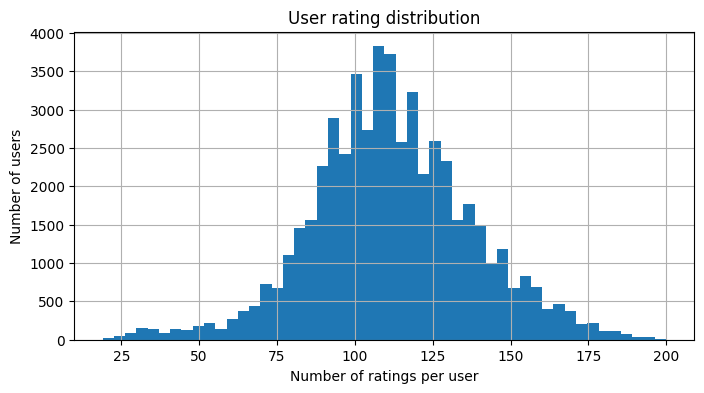

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
user_rating_counts.hist(bins=50)
plt.xlabel('Number of ratings per user')
plt.ylabel('Number of users')
plt.title('User rating distribution')
plt.show()

From the distribution we can see that most users give between **80-130** ratings and the apex is around **110**.

The following plots a histogram to visualize the distribution of rating values across all user book ratings.

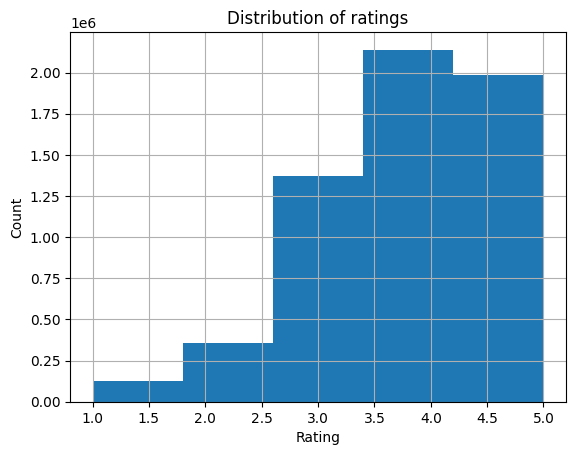

In [118]:
df_ratings['rating'].hist(bins=5)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of ratings')
plt.show()

The histogram shows that most ratings are between **3** and **5**, with **4** the most common. This means that users generally rate books positively. The skew toward higher (left skewed) ratings may make the model favor positive predictions.

The following plots a histogram to visualize the distribution of number of ratings per book.

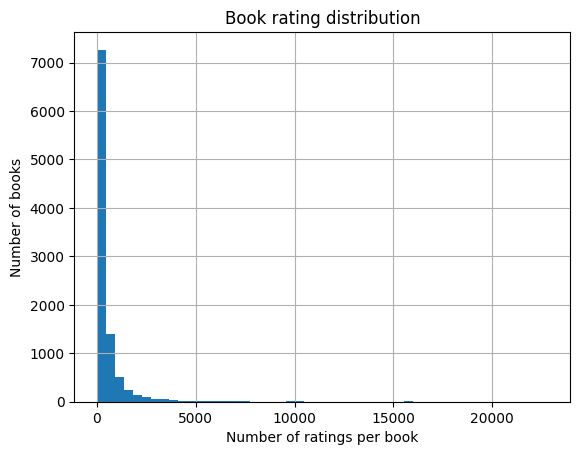

In [119]:
book_rating_counts = df_ratings.groupby('book_id').size()
book_rating_counts.hist(bins=50)
plt.xlabel('Number of ratings per book')
plt.ylabel('Number of books')
plt.title('Book rating distribution')
plt.show()

The histogram shows that most books have been rated only few times and that small number of books have received many ratings. The distribution is highly **right skewed** meaning this can make SVD focus more on popular books.

**In conclusion** the both datasets: *books_enriched.csv (using book_id, title)* and *ratings.csv (using user_id, book_id, rating)* are clean and ready for analysis. The datatypes in the *books* dataset are correct for the needed feature columns, and the small amount of missing data in *books* dataset doesn't affect SVD. The *ratings* dataset is complete, with no missing values and feature columns are of appropriate datatype, making it also ready for modeling.

# 3. Data preparation

The next phase is to prepare the data for modeling. As found in the **data understanding** phase, the datasets were already clean and in good shape, therefore they needed minimal preprocessing. 

The **Surprise library** is used for building and evaluating recommender systems, and it requires the data to be in a specific three column format (user_id, book_id, and rating). An additional set of user ratings was included in the dataset to support later evaluation.

The data was formatted for use with the library, split into training and test sets, and a folder was created to store the trained model for later use without the need for retraining.

For the purpose of making the **results** and **evaluation** more interesting, a new user based on the ratings of a known real user (project member Ade) is added to the ratings dataframe. The ratings are stored in a separate CSV file and imported, then concatenated to the main ratings dataframe.

In [120]:
# project member Ade's ratings
df_ratings_ade = pd.read_csv("datasets/book_recommender/book_ratings_ade.csv")
# combine Ade's ratings with main ratings dataset
df_ratings_2 = pd.concat([df_ratings, df_ratings_ade], ignore_index=True)

The following table displays the first **10 books** rated by the known user (Ade), ordered by rating value:

In [121]:
# merge Ade's ratings with book titles
df_merged = df_ratings_ade.merge(df_books[['book_id', 'title']], on='book_id', how='left')
# keep only relevant columns and sort by rating
df_merged = df_merged[['title', 'rating']]
df_merged = df_merged.sort_values(by='rating', ascending=False).reset_index(drop=True)
# display top 10 rated books
df_merged.head(10)

,title,rating
0,"A Game of Thrones (A Song of Ice and Fire, #1)",5
1,"A Wizard of Earthsea (Earthsea Cycle, #1)",5
2,"The Tombs of Atuan (Earthsea Cycle, #2)",5
3,Pride and Prejudice,5
4,The Lightning Thief (Percy Jackson and the Oly...,5
5,Harry Potter and the Sorcerer's Stone (Harry P...,5
6,Harry Potter and the Prisoner of Azkaban (Harr...,5
7,Harry Potter and the Half-Blood Prince (Harry ...,5
8,Harry Potter and the Deathly Hallows (Harry Po...,4
9,Pippi Longstocking,4


The dataframe shows the books Ade rated highest (top 10), giving understanding into their preferences for testing the recommender later.

The following code shows how to load the ratings dataframe into Surprise's Dataset format. The rating scale is provided for the Reader class as **1-5**. This prepares the data for use with collaborative filtering models such as SVD and KNN.

In [122]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings_2[['user_id', 'book_id', 'rating']], reader)

Next, the data is split into training and test sets using an **80/20** split. The training set is used to train the SVD model, while the test set is used to evaluate its performance.

In [123]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Lastly for preparation, the **model storage** is set up so that the trained model can be **saved and reloaded** later without needing to retrain it each time, as this is time-consuming with large datasets.

In [124]:
import os

os.makedirs('book_recommender_model', exist_ok=True)
model_file = 'book_recommender_model/svd_model.pkl'

The data preparation is complete. The main task was converting the ratings dataframe into Surprise's Dataset format and splitting it into training and test sets (80/20 split). The data is now ready for modeling.

# 4. Modeling

In this phase, the **Singular Value Decomposition (SVD)** algorithm from the Surprise library is used for its effectiveness in collaborative filtering tasks. The model is either loaded from disk if it exists or trained on the training set if not. After training, the model is saved for future use. Finally, a function is defined to get the top N book recommendations for a given user based on predicted ratings.
This phase selects the recommendation algorithm, trains (or loads) the model, and validates its performance.

#### **Singular value decomposition**

Initially, a **k-Nearest Neighbors** (kNN) based collaborative filtering algorithm was implemented (KNNBasic from scikit-surprise). However, the model ran into memory issues during training. This happened because **kNN-recommenders** compute and store a full similarity matrix between all users. With a dataset as large as the one used in this project, the matrix becomes extremely large and requires more memory than is available. To address this, the kNN algorithm was replaced with **Singular Value Decomposition (SVD)**, which is more memory efficient and scales better to large datasets.

Singular value decomposition (SVD) is a **collaborative filtering algorithm** that **decomposes the user-item (user-book) rating matrix into three lower-dimensional matrices**: user features, item features, and singular values. User features capture latent factors representing user preferences, item features capture latent factors representing item characteristics, and singular values indicate the importance of each latent factor. By reducing the dimensionality of the data, SVD can generalize better to the user-item pairs to be predicted as well as make accurate predictions even with sparse data. For this reason, it also works well with large datasets.

The decomposition captures **latent factors** that explain user preferences and item characteristics. In the real world, these factors could represent genres, themes, or styles that influence each user's ratings. They are however not directly interpretable as the ratings dataset consists of only user IDs, book IDs, and ratings without any additional metadata.

The number of latent factors is a **hyperparameter k (`n_factors`)** that can be tuned to optimize performance. More factors can capture more complex patterns but may lead to overfitting, while fewer factors may underfit the data. The SVD algorithm learns these latent factors by minimizing the error between predicted and actual ratings in the training set using stochastic gradient descent. In practise, the algorithm iterates over the training data multiple times (`n_epochs`, where default  is 20 times), updating the latent factor matrices to reduce the prediction error.

**The final prediction for a user-item pair is computed as the dot product** of the corresponding user and item latent factor vectors, plus any bias terms. These bias terms account for systematic tendencies of users to rate higher or lower than average, and items to receive higher or lower ratings than average. Finally, the predicted rating is converted to the provided rating range (1-5 in this case).

#### **Hyperparameter tuning**

The following code performs hyperparameter tuning for the SVD model by testing different values for `n_factors` (number of latent factors). The model is trained and evaluated in parallel for efficiency, and the results are printed along with the best performing hyperparameters. The validation is done with the test set using **RMSE** and **MAE** metrics.

In [125]:
from joblib import Parallel, delayed
from surprise import SVD, accuracy

# hyperparameters to try
n_factors_list = [20, 50, 100]

# create parameter sets
params_list = [{'n_factors': f} for f in n_factors_list]

# train and evaluate model with given hyperparameters
def evaluate_params(params):
    algo_t = SVD(**params, random_state=42)
    algo_t.fit(trainset)
    predictions_t = algo_t.test(testset)
    rmse_t = accuracy.rmse(predictions_t, verbose=False)
    mae_t = accuracy.mae(predictions_t, verbose=False)
    return params, rmse_t, mae_t

# run evaluations in parallel
results = Parallel(n_jobs=-1)(delayed(evaluate_params)(p) for p in params_list)

# print all results
for params, rmse, mae in results:
    print(f"Params: {params}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# print best result
best = min(results, key=lambda x: x[1])
print(f"Best results: RMSE: {best[1]:.4f}, MAE: {best[2]:.4f} with params: {best[0]}")

Params: {'n_factors': 20}, RMSE: 0.8320, MAE: 0.6446
Params: {'n_factors': 50}, RMSE: 0.8307, MAE: 0.6421
Params: {'n_factors': 100}, RMSE: 0.8310, MAE: 0.6412
Best results: RMSE: 0.8307, MAE: 0.6421 with params: {'n_factors': 50}


It is observed that **`n_factors=50` gives the best performance** with RMSE of **0.8302** and MAE of **0.6414**, although all tested values perform similarly. The parameter `n_factors=50` is thus chosen for the final model as it balances complexity and performance well.

#### **Training the final model**

The final SVD model is either loaded from disk if it exists or trained on the training set if not. After training, the model is saved as a pickle file, so it can be reused without retraining.

In [126]:
from surprise import SVD, dump

if os.path.exists(model_file):
    print("Loading saved model")
    _, algo = dump.load(model_file)
else:
    print("Training new model")
    algo = SVD(n_factors=50, random_state=42)
    algo.fit(trainset)
    dump.dump(model_file, algo=algo)
    print("Model saved to", model_file)

Loading saved model


#### **Results**

The following function `get_top_n` generates a ranked list of book recommentations for a specific user based on the trained SVD model.

In [127]:
def get_top_n(user_id, n):
    all_books = trainset.all_items()
    all_books_ids = [trainset.to_raw_iid(i) for i in all_books]

    # get all books the user has already rated
    try:
        inner_uid = trainset.to_inner_uid(user_id)
        rated_books = set([trainset.to_raw_iid(i) for (i, _) in trainset.ur[inner_uid]])
    except ValueError:
        # user not in trainset
        rated_books = set()

    # get all books the user has not rated yet
    unrated_books = [book_id for book_id in all_books_ids if book_id not in rated_books]

    # predict ratings for all books for the user
    predictions = [algo.predict(user_id, book_id) for book_id in unrated_books]

    # sort predictions by estimated rating, descending
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    return [(pred.iid, pred.est) for pred in top_n]

After the model is trained and the recommendation function is defined, the model is tested by generating top 10 book recommendations for a specific user (chosen by ID in `df_ratings_2`). The book titles are retrieved from `df_books` using the predicted book IDs.

The following prints the recommendations for the known user (project member Ade):

In [128]:
RECS_N = 10 # number of recommendations to generate
USER = 99999

print(f"Top 10 recommendations for user {USER}:")
for iid, score in get_top_n(USER, RECS_N):
    book_title = df_books.loc[df_books['book_id'] == int(iid), 'title'].values[0]
    print(f"{book_title}: {score:.2f}")

Top 10 recommendations for user 99999:
The Divan: 4.50
Jesus the Christ: 4.40
The Complete Calvin and Hobbes: 4.34
The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury: 4.33
Attack of the Deranged Mutant Killer Monster Snow Goons: 4.29
Preach My Gospel: A Guide To Missionary Service: 4.29
Words of Radiance (The Stormlight Archive, #2): 4.27
The Arrival: 4.26
The Calvin and Hobbes Tenth Anniversary Book: 4.24
The Absolute Sandman, Volume One: 4.21


The top 10 recommendations for Ade shows a mix of genres, with predicted ratings ranging from **4.2 to 4.5**.

The following prints the recommendations for an unknown user with **ID 44265**:

In [129]:
RECS_N = 10 # number of recommendations to generate
USER = 44265

print(f"Top 10 recommendations for user {USER}:")
for iid, score in get_top_n(USER, RECS_N):
    book_title = df_books.loc[df_books['book_id'] == int(iid), 'title'].values[0]
    print(f"{book_title}: {score:.2f}")

Top 10 recommendations for user 44265:
Down and Out in Paris and London: 5.00
A Wind in the Door (A Wrinkle in Time Quintet, #2): 5.00
North and South (North and South, #1): 5.00
The First Commandment (Scot Harvath, #6): 5.00
The Lies of Locke Lamora (Gentleman Bastard, #1): 5.00
One Hundred Years of Solitude: 5.00
Dead Witch Walking (The Hollows, #1): 5.00
A Visit from the Goon Squad: 5.00
The Guardian: 5.00
Goodnight Moon: 5.00


The top 10 recommendations for **user 44265** all have a predicted rating of **5.00**. Meaning the model expects the user to really like all of these books.

# 5. Evaluation

The model's performance is evaluated using **Root Mean Squared Error (RMSE)** and **Mean Absolute Error (MAE)** metrics from the Surprise library. These metrics measure how close the predicted ratings are to the actual ratings in the test set. Lower values indicate better performance.

In [130]:
from surprise import accuracy

predictions = algo.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.8320
MAE:  0.6446


0.6446165636360923

The **RMSE** of **0.83** and **MAE** of **0.64** indicate that the model’s predicted ratings are, on average, within about **0.6** to **0.8** distance of the actual user ratings on a **1–5** scale.

To visualize the distribution of absolute errors between predicted and true ratings, a histogram is plotted.

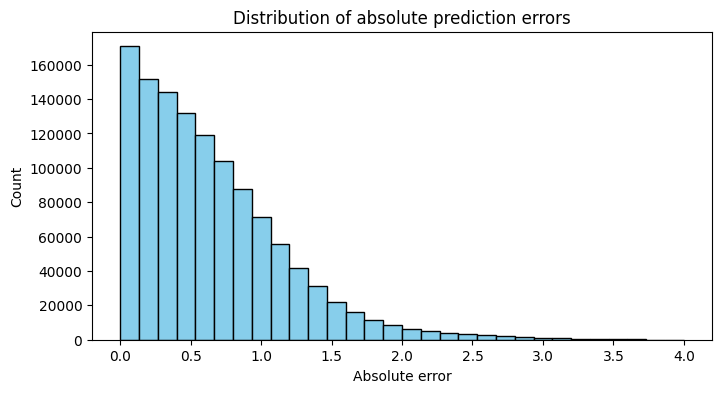

In [131]:
errors = [abs(true_r - est) for (_, _, true_r, est, _) in predictions]

plt.figure(figsize=(8,4))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of absolute prediction errors')
plt.xlabel('Absolute error')
plt.ylabel('Count')
plt.show()

From the plot, we can see that most prediction errors are small, and only few predictions have errors larger than the **RMSE** value of **0.83**. This indicates that the model is generally accurate in predicting user ratings.

### RMSE and MAE standards comparison

In the context of a 1–5 rating scale, what is considered an *acceptable* level of accuracy depends on factors such as data sparsity (which in this data is high), inherent noise in the dataset, and the specific domain of application. Baseline models that rely on simple predictors, such as global, user, or item means, typically achieve RMSE values in the range of 0.95 to 1.15 and MAE values between 0.70 and 0.85. With SVD, the model generally performs better on sparse public datasets, often reaching RMSE values around 0.80 to 0.90 and MAE values around 0.60 to 0.70.

Given these benchmarks, the obtained results of **RMSE 0.83** and **MAE 0.64** can be considered **solid and well within the "good" range**, especially considering the sparsity of the dataset. This indicates that the model captures meaningful patterns in user preferences and produces predictions that are generally accurate.

| Model Type / Benchmark           | RMSE Range | MAE Range | Interpretation                  |
|----------------------------------|------------|-----------|----------------------------------|
| Baseline (global/user/item mean) | 0.95–1.15  | 0.70–0.85 | Typical simple predictor performance |
| Collaborative Filtering (SVD)    | 0.80–0.90  | 0.60–0.70 | Typical performance on sparse datasets |
| Good performance threshold        | < 0.85     | < 0.65    | Indicates accurate and consistent predictions |
| **This model (SVD result)**       | **0.83**   | **0.64**  | **Solid performance within the “good” range** |

### Analysis of recommendation results

The top recommendations for the known user (project member Ade) consist mostly of popular books without a clear connection to the original book ratings. The original ratings consisted of mostly fantasy and science fiction books but this is not reflected in the recommendations. This is most likely caused by the fact that Ade has rated a relatively small number of books (48) compared to the average user. This gives the model limited information to learn from, thus recommending generally popular books that many users have rated highly. This is unfortunately a common issue in recommender systems known as the **cold-start problem**.

The predicted ratings for the unknown user (ID 44265) give more varied results as they do not consist of the most popular books. It is observed that all ratings are predicted as 5 stars, which is likely due to the fact that this user has given many 5 star ratings in their original ratings. The next table shows the distribution of this user's original ratings:

In [132]:
user_44265_ratings = df_ratings_2.loc[df_ratings_2['user_id'] == 44265, 'rating'].value_counts().sort_index()
user_44265_ratings

rating
3      1
4      2
5    110
Name: count, dtype: int64

As seen from the table, the assumption is correct that the user has rated most books at 5 stars, leading the model to predict high ratings for the recommendations as well. The user has rated 113 books in total, which is around the average, meaning the amount of ratings a user has to give to receive more personalized recommendations is likely around **100**.

Overall, the recommendations for both users are reasonable given their rating histories, but the model's performance is limited by the amount of data available for each user. It is estimated that around **100** ratings are needed for the model to predict more personalized recommendations, as in general, the more ratings a user has, the better the recommendations will be.

Additionally, expanding the book dataset to include more titles could improve the variety and relevance of the recommendations, as the current dataset only contains **10000** books, with the newest published over five years ago. This represents a relatively small fraction of even the most popular books. There is also the possibility to remove very popular books from the dataset to reduce bias toward them but this could be seen as a controversial choice.

### Evaluation of model accuracy

The model can give useful and relevant book recommendations, but there is still room for improvement. One possible enhancement would be **hyperparameter tuning**, where different values for additional parameters such as `n_epochs` are tested to optimize performance and reduce prediction error. Another issue to consider is the **cold-start problem**, which occurs when new users or books have few or no ratings, leading to less accurate recommendations due to minimal data. Additionally, the model may exhibit a **bias toward popular items**, meaning it could prioritize books with many existing ratings while overlooking less-known titles that might better match individual user preferences.

# 6. Deployment

The recommender can now be used to give insightful recommendations to avid bookworms on what they might want to read next, by analyzing user book rating patterns and predicting how much a user would like books they haven’t yet rated. The **SVD algorithm**, which the model is also based on, has been proven to be excellent for recommender systems handling large datasets, making the model more scalable and futureproof, assuming the dataset keeps growing in size with an influx of new users and ratings.

Currently, to get recommendations a rating profile must be constructed and predictions applied manually, but a proper **application or a webpage** should be constructed for a better user experience. Alternatively, the recommender could be integrated into an already **existing e-commerce or reading platform**. In an application, users could rate books and based on their rating history the application would recommend new books. To make the experience smoother for new users and battle the **cold-start problem**, a default recommender algorithm should be constructed based on e.g. popular or highly rated books.

The performance of the recommender should be **monitored over time**, as most of the ratings in the data are very high, which leads the model to predict similarly high ratings. This can be especially rough for new users, or users with a low amount of ratings, as the model might rate a lot of very different books very highly, and thus not give very meaningful recommendations.

**Answering the research question:**
<br>
The results show that the **SVD-based collaborative filtering model** can accurately predict user ratings with low error rates (RMSE ≈ 0.83, MAE ≈ 0.64) and provide book recommendations that generally align with users’ preferences. While the predictions tend to favor higher ratings, the model succeeds in identifying relevant books and demonstrates the potential of SVD for personalized book recommendations.